In [1]:
#这次对小数据集进行词级别的机器翻译
import torch
import torch.utils.data as da
import torch.nn as nn
import torch.optim as optim
import jieba
import argparse
import matplotlib.pyplot as plt
from collections import Counter
import random
import time
from tqdm import tqdm
import torch.nn.functional as F

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
parser = argparse.ArgumentParser()

parser.add_argument('--en_path', type=str, default='data/news-commentary-v13.zh-en.en',
                   help='英文数据集路径')
parser.add_argument('--zh_path', type=str, default='data/news-commentary-v13.zh-en.zh',
                   help='中文数据集路径')
parser.add_argument('--seq_len', type=int, default=100,
                   help='句子最大的长度，多则截断，少则补<unk>')
parser.add_argument('--pad', type=str, default='<unk>',
                   help='填充词')
parser.add_argument('--batch_size',type=int,default=32,
                   help='每轮批次')
parser.add_argument('--en_embedding_dim',type=int,default=256,
                   help='编码器词向量的长度')
parser.add_argument('--en_hidden_dim',type=int,default=512,
                   help='编码器深度')
parser.add_argument('--en_n_layers',type=int,default=2,
                   help='编码器LSTM的层数')
parser.add_argument('--de_embedding_dim',type=int,default=256,
                   help='解码器词向量的长度')
parser.add_argument('--de_hidden_dim',type=int,default=512,
                   help='解码器深度')
parser.add_argument('--de_n_layers',type=int,default=2,
                   help='解码器LSTM的层数')
parser.add_argument('--dropout',type=int,default=0.5,
                   help='droput')
parser.add_argument('--lr',type=int,default=0.0001,
                   help='学习率')
parser.add_argument('--weight_decay',type=int,default=0.1,
                   help='权重衰减/L2范式')
parser.add_argument('--clip',type=int,default=1,
                   help='梯度剪切')
parser.add_argument('--epochs',type=int,default=200,
                   help='训练轮数')
parser.add_argument('--attention',type=bool,default=False,
                   help='是否启用注意力机制')

#kwargs = parser.parse_args()
kwargs = parser.parse_known_args()[0]


In [4]:
with open(kwargs.en_path, 'r') as f_en:
    data_en = f_en.readlines()
with open(kwargs.zh_path, 'r') as f_zh:
    data_zh = f_zh.readlines()

In [5]:
#特殊处理
def data_process(text):
    text = text.lower()
    # 特殊数据处理，该地方可以各种替换缩略词等
    # 去除标点等
    return text

In [6]:
#对单句话进行分词
def get_token_text(text_en,text_zh):
    #简单的句子处理
    text_en=text_en.replace('.',' .').replace('?',' ?').replace('!',' !').replace(',',' , ')
    text_zh=text_zh.strip('\n')
    #英文以空格分割
    token_data_en = [data_process(st) for st in text_en.split()]
    #中文一般用jieba
    token_data_zh = [data_process(st) for st in jieba.cut(text_zh)]
    return [token_data_en,token_data_zh]

In [7]:
#对两个数据集的每句话进行分词
def get_token_data(data_en,data_zh):
    data_token_en = []
    data_token_zh = []
    for en,zh in zip(data_en,data_zh):
        en,zh=get_token_text(en,zh)
        data_token_en.append(en)
        data_token_zh.append(zh)
    return data_token_en,data_token_zh

In [8]:
def get_vocab(data):
    data=[j for i in data for j in i]
    top_1000 = Counter(data).most_common(100000)
    vocab = {x[0]:x[1] for x in top_1000}
    word_to_idx = {word: i + 4 for i, word in enumerate(vocab)}
    word_to_idx['<pad>'] = 0
    word_to_idx['<sos>'] = 1
    word_to_idx['<eos>'] = 2
    word_to_idx['<unk>'] = 3
    idx_to_word = {i + 4: word for i, word in enumerate(vocab)}
    idx_to_word[0] = '<pad>'
    idx_to_word[1] = '<sos>'
    idx_to_word[2] = '<eos>'
    idx_to_word[3] = '<unk>'
    vocab_size=len(idx_to_word)
    return vocab, vocab_size, word_to_idx, idx_to_word

In [9]:
# 填充和截断
def pad_st(features, maxlen, pad=0):
    padded_features = []
    for feature in features:
        feature.insert(0,'<sos>')
        feature.append('<eos>')
        if len(feature) > maxlen:
            padded_feature = feature[:maxlen]
            padded_feature[-1]='<eos>'#防止<eos>被切掉
        else:
            padded_feature = feature
            while (len(padded_feature) < maxlen):
                padded_feature.append(pad)
        padded_features.append(padded_feature)
    return padded_features

In [10]:
# 转化为索引
def encode_st(token_data, word_to_idx):
    features = []
    for sample in token_data:
        feature = []
        feature.append(1)
        for token in sample:
            if token in word_to_idx:
                feature.append(word_to_idx[token])
            else:#如果是词库中不存在的，认为是<unk>，即0
                feature.append(0)
        feature.append(2)
        features.append(feature)
    
    return features

In [11]:
#此时为二维数组，每个数组是之前每句话的分词结果，词级别
en_data,zh_data=get_token_data(data_en,data_zh)
en_data,zh_data=en_data[:10000],zh_data[:10000]

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Dumping model to file cache /tmp/jieba.cache
Dump cache file failed.
Traceback (most recent call last):
  File "/home/renhongjie/miniconda3/envs/rencaiji/lib/python3.6/site-packages/jieba/__init__.py", line 154, in initialize
    _replace_file(fpath, cache_file)
PermissionError: [Errno 1] Operation not permitted: '/tmp/tmp__7dd0m9' -> '/tmp/jieba.cache'
Loading model cost 0.837 seconds.
Prefix dict has been built successfully.


In [12]:
print(en_data[0:2],zh_data[0:2])

[['1929', 'or', '1989', '?'], ['paris', '–', 'as', 'the', 'economic', 'crisis', 'deepens', 'and', 'widens', ',', 'the', 'world', 'has', 'been', 'searching', 'for', 'historical', 'analogies', 'to', 'help', 'us', 'understand', 'what', 'has', 'been', 'happening', '.']] [['1929', '年', '还是', '1989', '年', '?'], ['巴黎', '-', '随着', '经济危机', '不断', '加深', '和', '蔓延', '，', '整个', '世界', '一直', '在', '寻找', '历史', '上', '的', '类似', '事件', '希望', '有助于', '我们', '了解', '目前', '正在', '发生', '的', '情况', '。']]


In [13]:
vocab_en,vocab_size_en, word_to_idx_en, idx_to_word_en=get_vocab(en_data)
vocab_zh,vocab_size_zh, word_to_idx_zh, idx_to_word_zh=get_vocab(zh_data)


In [14]:
kwargs.vocab_size_en=vocab_size_en#记录vocab大小
kwargs.vocab_size_zh=vocab_size_zh#记录vocab大小
print(vocab_size_en,vocab_size_zh)

18993 19027


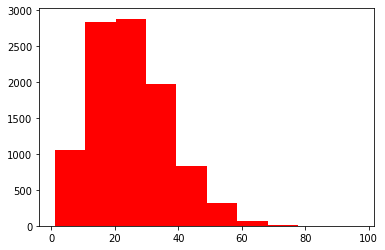

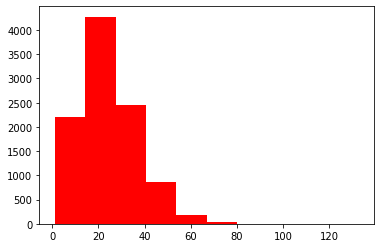

In [15]:
#看一下预料的长度分布，然后选择一个合适的seq_len
en_data_length=[]
for i in en_data:
    en_data_length.append(len(i))
n, bins, patches = plt.hist(en_data_length, bins=10, edgecolor='None',facecolor='red') 
plt.show()
zh_data_length=[]
for i in zh_data:
    zh_data_length.append(len(i))
n, bins, patches = plt.hist(zh_data_length, bins=10, edgecolor='None',facecolor='red') 
plt.show()

In [16]:
print(zh_data_length[0:10])

[6, 29, 37, 44, 23, 35, 27, 15, 45, 39]


In [17]:
en_data_id=encode_st((en_data),word_to_idx_en)
zh_data_id=encode_st((zh_data),word_to_idx_zh)

In [18]:
print(en_data_id[0:3])

[[1, 6920, 41, 1532, 113, 2], [1, 1051, 15, 16, 4, 50, 109, 5600, 9, 9721, 5, 4, 43, 25, 46, 3228, 14, 1011, 6921, 8, 206, 23, 984, 78, 25, 46, 2692, 6, 2], [1, 36, 4, 534, 7, 4, 109, 5, 66, 90, 6922, 17, 8, 6923, 41, 2693, 5, 42, 35, 2694, 5, 110, 118, 6924, 4724, 8, 3603, 2484, 5601, 6, 2]]


In [19]:
from torch.utils.data import Dataset, DataLoader
class TranslationDataset(Dataset):
    def __init__(self, src_data, trg_data):
        self.src_data = src_data
        self.trg_data = trg_data

        assert len(src_data) == len(trg_data), \
            "numbers of src_data  and trg_data must be equal!"

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, idx):
        src_sample =self.src_data[idx]
        src_len = len(self.src_data[idx])
        trg_sample = self.trg_data[idx]
        trg_len = len(self.trg_data[idx])
        return {"src": src_sample, "src_len": src_len, "trg": trg_sample, "trg_len": trg_len}

In [20]:
def padding_batch(batch):
    """
    input: -> list of dict
        [{'src': [1, 2, 3], 'trg': [1, 2, 3]}, {'src': [1, 2, 2, 3], 'trg': [1, 2, 2, 3]}]
    output: -> dict of tensor 
        {
            "src": [[1, 2, 3, 0], [1, 2, 2, 3]].T
            "trg": [[1, 2, 3, 0], [1, 2, 2, 3]].T
        }
    """
    src_lens = [d["src_len"] for d in batch]
    trg_lens = [d["trg_len"] for d in batch]
    
    src_max = max([d["src_len"] for d in batch])
    trg_max = max([d["trg_len"] for d in batch])
    for d in batch:
        word_to_idx_en
        d["src"].extend([word_to_idx_en["<pad>"]]*(src_max-d["src_len"]))
        d["trg"].extend([word_to_idx_zh["<pad>"]]*(trg_max-d["trg_len"]))
    srcs = torch.tensor([pair["src"] for pair in batch], dtype=torch.long, device=device)
    trgs = torch.tensor([pair["trg"] for pair in batch], dtype=torch.long, device=device)
    
    batch = {"src":srcs.T, "src_len":src_lens, "trg":trgs.T, "trg_len":trg_lens}
    return batch

In [21]:
# 数据集
train_set = TranslationDataset(en_data_id, zh_data_id)
train_iter = DataLoader(train_set, batch_size=kwargs.batch_size, collate_fn=padding_batch)

In [22]:
#开始模型部分
class Encoder(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.input_dim = args.vocab_size_en
        self.emb_dim = args.en_embedding_dim
        self.hid_dim = args.en_hidden_dim
        self.n_layers = args.en_n_layers
        self.dropout = args.dropout
        self.embedding = nn.Embedding(self.input_dim, self.emb_dim)   
        self.rnn = nn.LSTM(input_size=self.emb_dim, hidden_size=self.hid_dim, num_layers=self.n_layers,
                           dropout=self.dropout,bidirectional=True)

        
    def forward(self, x,input_lengths):
        embedded = (self.embedding(x))
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths, enforce_sorted=False)
        outputs, (hidden, cell) = self.rnn(packed)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(sequence=outputs)
        return outputs,hidden, cell
class Decoder(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.emb_dim = args.de_embedding_dim
        self.hid_dim = args.de_hidden_dim
        self.output_dim = args.vocab_size_zh
        self.n_layers = args.de_n_layers
        self.dropout = args.dropout
        self.embedding = nn.Embedding(self.output_dim, self.emb_dim)
        self.rnn = nn.LSTM(input_size=self.emb_dim, hidden_size=self.hid_dim,num_layers= self.n_layers,
                           dropout=self.dropout,bidirectional=True)
        bidirectional=True
        if bidirectional==True:
            self.out = nn.Linear(self.hid_dim*2, self.output_dim)
        else:
            self.out = nn.Linear(self.hid_dim, self.output_dim)
        self.dropout = nn.Dropout(self.dropout)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, hidden, cell):
        batch_size = x.size(0)
        embedded = self.dropout(self.embedding(x).view(1, batch_size, -1))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))       
        output = self.out(output.squeeze(0))
        prediction = self.softmax(output)
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, args,device):
        super().__init__()
        self.attention=args.attention
        self.encoder = Encoder(args)
        if self.attention==True:
            self.decoder = DecoderAtten(args)
        else:
            self.decoder = Decoder(args)
        self.device = device
        
        assert self.encoder.hid_dim == self.decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert self.encoder.n_layers == self.decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, src_length,trg_length,teacher_forcing_ratio = 0.5):
        batch_size = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        max_target_length = max(trg_length)
        outputs = torch.zeros(max_target_length, batch_size, trg_vocab_size).to(self.device)
        en_outputs,hidden, cell = self.encoder(src,src_length)   
        #输入到Decoder网络的第一个字符是<sos>（句子开始标记）
        de_input = trg[0]
        
        for t in range(max_target_length):
            #注意前面的hidden、cell和后面的是不同的
#             if self.attention==True:
#                 output, hidden, cell = self.decoder(de_input, hidden, cell,en_outputs)
#             else:
#                 output, hidden, cell = self.decoder(de_input, hidden, cell)
#             outputs[t] = output
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
            if use_teacher_forcing:
                    # decoder_output = [batch, output_dim]
                    # decoder_hidden = [n_layers*n_directions, batch, hid_dim]
                    output, hidden, cell = self.decoder(de_input, hidden, cell)
                    outputs[t] = output
                    output = trg[t]  # 下一个输入来自训练数据
            else:
                    output, decoder_hidden, cell = self.decoder(de_input, hidden, cell)
                    # [batch, 1]
                    topv, topi = output.topk(1)
                    outputs[t] = output
                    output = topi.squeeze(1)  # 
        return outputs

In [23]:
def train(args,device,model,train_iter):
    moedel=model.to(device)
    loss_function = nn.NLLLoss(ignore_index = 0)
    #optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    print("模型开始训练")
    for epoch in range(args.epochs):
        start = time.time()
        train_loss, train_acc = 0, 0
        n= 0
        model.train()
        for i,(batch) in enumerate(tqdm(train_iter)):
            n += 1
            input_batchs = batch["src"].to(device)
            target_batchs = batch["trg"].to(device)
            # list
            input_lens = batch["src_len"]
            target_lens = batch["trg_len"]
            optimizer.zero_grad()
            output = model(input_batchs, target_batchs,input_lens,target_lens)
            #print(output.is_contiguous(),trg.is_contiguous())
#             output = output.contiguous().view(-1, output.shape[-1])
#             target_batchs = target_batchs.contiguous().view(-1)
            loss = loss_function(output.reshape(-1,output.shape[-1] ), target_batchs.reshape(-1))
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
            optimizer.step()
            train_loss += loss
        end = time.time()
        runtime = end - start
        print(
            'epoch: %d, train loss: %.4f,time: %.4f \n' % (epoch, train_loss.data / n,runtime)
        )

In [24]:
model=Seq2Seq(kwargs,device)
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(18993, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(19027, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5, bidirectional=True)
    (out): Linear(in_features=1024, out_features=19027, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (softmax): LogSoftmax(dim=1)
  )
)


In [ ]:
train(kwargs,device,model,train_iter)

  0%|          | 0/313 [00:00<?, ?it/s]

模型开始训练


  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 0, train loss: 7.0601,time: 100.6559 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 1, train loss: 6.6786,time: 99.7407 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 2, train loss: 6.6196,time: 99.4473 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 3, train loss: 6.5756,time: 99.7149 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 4, train loss: 6.5267,time: 99.7466 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 5, train loss: 6.4767,time: 99.8190 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 6, train loss: 6.4260,time: 99.7624 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 7, train loss: 6.3751,time: 99.6209 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 8, train loss: 6.3224,time: 99.8119 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 9, train loss: 6.2696,time: 100.0701 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 10, train loss: 6.2136,time: 99.9567 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 11, train loss: 6.1617,time: 100.1858 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 12, train loss: 6.1086,time: 100.0294 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 13, train loss: 6.0567,time: 99.9851 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 14, train loss: 6.0070,time: 100.6117 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 15, train loss: 5.9535,time: 100.4095 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 16, train loss: 5.9087,time: 100.4585 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 17, train loss: 5.8634,time: 99.8810 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 18, train loss: 5.8053,time: 100.3471 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 19, train loss: 5.7538,time: 100.3523 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 20, train loss: 5.7003,time: 100.1921 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 21, train loss: 5.6468,time: 100.5816 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 22, train loss: 5.6019,time: 100.5206 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 23, train loss: 5.5446,time: 100.6688 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 24, train loss: 5.4901,time: 100.6002 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 25, train loss: 5.4430,time: 100.4415 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 26, train loss: 5.3910,time: 100.2732 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 27, train loss: 5.3330,time: 100.3371 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 28, train loss: 5.2831,time: 100.2008 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 29, train loss: 5.2236,time: 100.3355 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 30, train loss: 5.1716,time: 100.1112 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 31, train loss: 5.1099,time: 100.1457 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 32, train loss: 5.0717,time: 100.4522 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 33, train loss: 5.0241,time: 100.2045 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 34, train loss: 4.9724,time: 100.1112 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 35, train loss: 4.9141,time: 99.6745 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 36, train loss: 4.8582,time: 100.2364 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 37, train loss: 4.7999,time: 100.0672 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 38, train loss: 4.7423,time: 100.2746 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 39, train loss: 4.6887,time: 99.9159 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 40, train loss: 4.6379,time: 100.0848 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 41, train loss: 4.5963,time: 100.1479 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 42, train loss: 4.5606,time: 100.0923 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 43, train loss: 4.5107,time: 100.3066 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 44, train loss: 4.4475,time: 100.5280 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 45, train loss: 4.4023,time: 100.3898 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 46, train loss: 4.3414,time: 100.2466 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 47, train loss: 4.2899,time: 99.9026 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 48, train loss: 4.2432,time: 100.4737 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 49, train loss: 4.1893,time: 100.2590 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 50, train loss: 4.1598,time: 100.5354 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 51, train loss: 4.1089,time: 100.6522 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 52, train loss: 4.0733,time: 100.5349 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 53, train loss: 4.0324,time: 100.5949 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 54, train loss: 3.9906,time: 100.5030 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 55, train loss: 3.9365,time: 100.4039 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 56, train loss: 3.8915,time: 100.2922 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 57, train loss: 3.8491,time: 99.9301 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 58, train loss: 3.8130,time: 100.4174 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 59, train loss: 3.7653,time: 100.4901 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 60, train loss: 3.7270,time: 100.5775 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 61, train loss: 3.6791,time: 99.9816 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 62, train loss: 3.6390,time: 100.2028 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 63, train loss: 3.6025,time: 100.5651 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 64, train loss: 3.5582,time: 100.2734 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 66, train loss: 3.4782,time: 100.4317 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 67, train loss: 3.4475,time: 99.5500 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 68, train loss: 3.3990,time: 100.4082 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 69, train loss: 3.3792,time: 100.2455 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 70, train loss: 3.3337,time: 100.0923 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 71, train loss: 3.2961,time: 100.1564 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 72, train loss: 3.2605,time: 99.9459 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 73, train loss: 3.2176,time: 99.9597 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 74, train loss: 3.1835,time: 99.7356 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 75, train loss: 3.1392,time: 99.6555 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 76, train loss: 3.1184,time: 99.6938 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 77, train loss: 3.0798,time: 99.6337 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 78, train loss: 3.0427,time: 100.4842 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 79, train loss: 3.0083,time: 100.2810 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 80, train loss: 2.9683,time: 100.3008 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 81, train loss: 2.9476,time: 99.7849 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 82, train loss: 2.9081,time: 100.0903 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 83, train loss: 2.8845,time: 99.8090 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 84, train loss: 2.8594,time: 99.9829 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 85, train loss: 2.7999,time: 99.8322 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 86, train loss: 2.7876,time: 99.3417 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 87, train loss: 2.7527,time: 99.7218 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 88, train loss: 2.7376,time: 99.5740 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 89, train loss: 2.7074,time: 99.6558 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 90, train loss: 2.6735,time: 100.2438 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 91, train loss: 2.6482,time: 100.8807 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 92, train loss: 2.6169,time: 101.1784 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 93, train loss: 2.5889,time: 100.8399 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 94, train loss: 2.5649,time: 101.1080 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 95, train loss: 2.5378,time: 101.0991 



  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 96, train loss: 2.5101,time: 101.4554 



 61%|██████    | 190/313 [01:00<00:41,  3.00it/s]

In [ ]:
torch.save(model, 's2s_ci_small.pkl')

In [ ]:
#简单测试一下，选第13个数据集进行测试
for i,(batch) in enumerate(tqdm(train_iter)):
            input_batchs = batch["src"].to(device)
            target_batchs = batch["trg"].to(device)
            # list
            input_lens = batch["src_len"]
            target_lens = batch["trg_len"]

            output = model(input_batchs, target_batchs,input_lens,target_lens)
            if i==13:
                break
print(output.shape)
output=output.argmax(2)
print(output.shape)
print(input_batchs.shape)
input_batchs=input_batchs.transpose(1,0)
output=output.transpose(1,0)
target_batchs=target_batchs.transpose(1,0)
for z,i in enumerate(output):
    print('\n原文：')
    for j in input_batchs[z]:
        if j.item()==2:
            break
        print(idx_to_word_en[j.item()],end='')
    print('\n正确答案：')
    for j in target_batchs[z]:
        if j.item()==2:
            break
        print(idx_to_word_zh[j.item()],end='')
    print('\n预测')
    for j in i:
        if j.item()==2:
            break
        print(idx_to_word_zh[j.item()],end='')

